In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gym
import random

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install gym

In [5]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/extracted_folder/ai_demand_waste_dataset.csv")
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df.set_index("date", inplace=True)

In [6]:
df

,sales_volume,ingredient_consumption,shelf_life_days,spoilage_risk,holiday_flag,promotion_flag,temperature,day_of_week,month
date,,,,,,,,,
2023-01-01,0.684564,0.000000,3,0.204984,0,0,0.768658,6,1
2023-01-02,0.617450,0.000000,9,0.293148,0,0,0.158313,0,1
2023-01-03,0.093960,0.528090,7,0.896336,0,0,0.612413,1,1
2023-01-04,0.711409,0.988764,7,0.013002,0,0,0.134614,2,1
2023-01-05,0.476510,0.000000,6,0.085509,0,0,0.754433,3,1
...,...,...,...,...,...,...,...,...,...
2023-12-27,0.845638,0.056180,8,0.430306,0,0,0.638443,2,12
2023-12-28,0.912752,0.584270,4,0.200525,0,0,0.917343,3,12
2023-12-29,0.932886,0.730337,4,0.491595,0,0,0.614775,4,12


In [12]:
# Handling missing values
df.ffill(inplace=True)

In [13]:
# Feature Engineering
df["day_of_week"] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
df["month"] = df.index.month  # 1 to 12

In [14]:
# Normalizing numerical data
scaler = MinMaxScaler()
df[["sales_volume", "ingredient_consumption", "temperature"]] = scaler.fit_transform(
    df[["sales_volume", "ingredient_consumption", "temperature"]]
)


In [15]:
# ------------------------- SALES FORECASTING MODEL (LSTM) -------------------------
sequence_length = 30  # Use last 30 days to predict next day
features = ["sales_volume", "day_of_week", "month"]

X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df[features].iloc[i:i+sequence_length].values)
    y.append(df["sales_volume"].iloc[i+sequence_length])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# LSTM Model
model = Sequential([
    Input(shape=(sequence_length, len(features))),  # Define Input layer
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [18]:
# Correct way to compile the model with metrics
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Correct way to fit the model (without metrics argument)
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.0000e+00 - loss: 1.1391 - val_accuracy: 0.0149 - val_loss: 0.1144
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0000e+00 - loss: 0.1707 - val_accuracy: 0.0149 - val_loss: 0.0987
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0000e+00 - loss: 0.1162 - val_accuracy: 0.0149 - val_loss: 0.0972
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0948 - val_accuracy: 0.0149 - val_loss: 0.0941
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0000e+00 - loss: 0.0976 - val_accuracy: 0.0149 - val_loss: 0.1067
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0000e+00 - loss: 0.0869 - val_accuracy: 0.0149 - val_loss: 0.0965
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0936 - val_accuracy: 0.0149 - val_loss: 0.1101
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0000e+00 - loss: 0

In [19]:
# Ensure model exists
if 'model' in locals():
    sales_predictions = model.predict(X_test)  # Generate predictions
    print(sales_predictions.shape)  # Check shape
else:
    print("Model is not defined. Train the model first.")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
(67, 1)


In [20]:
dummy_array = np.zeros((sales_predictions.shape[0], 3))  # Create dummy array
dummy_array[:, 0] = sales_predictions[:, 0]  # Place predictions in first column
sales_predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract first column


In [21]:
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1, 1))  # Fit only on target variable
sales_predictions = scaler.inverse_transform(sales_predictions.reshape(-1, 1))


In [22]:
# Sales Prediction
sales_predictions = model.predict(X_test)
sales_predictions = scaler.inverse_transform(sales_predictions[:, 0].reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


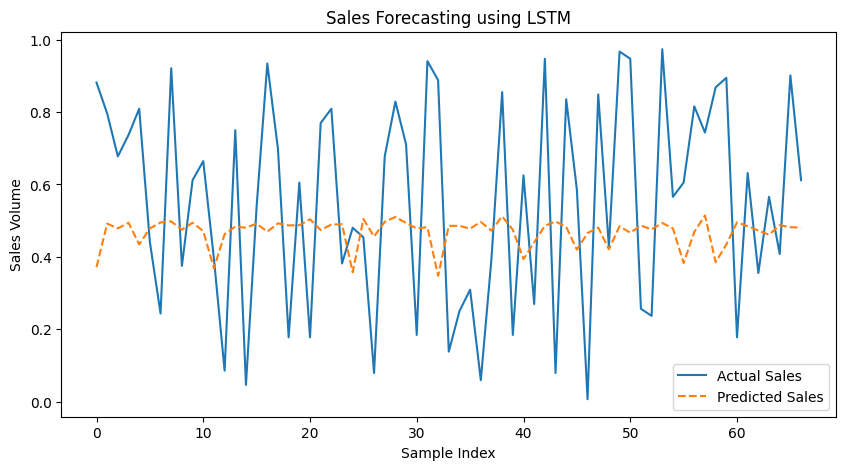

In [23]:
# Visualization - Sales Forecasting
plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual Sales")
plt.plot(sales_predictions, label="Predicted Sales", linestyle='dashed')
plt.xlabel("Sample Index")
plt.ylabel("Sales Volume")
plt.title("Sales Forecasting using LSTM")
plt.legend()
plt.show()

In [24]:
# ------------------------- WASTE PREDICTION MODEL (RandomForest & XGBoost) -------------------------
waste_features = ["sales_volume", "holiday_flag", "promotion_flag", "temperature", "day_of_week", "month"]
target = "ingredient_consumption"

X_train, X_test, y_train, y_test = train_test_split(df[waste_features], df[target], test_size=0.2, random_state=42)

In [25]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [26]:
# XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [28]:
# Waste Model Metrics
waste_model_metrics = {
    "RandomForest_MAE": mean_absolute_error(y_test, rf_predictions),
    "RandomForest_RMSE": np.sqrt(mean_squared_error(y_test, rf_predictions)),
    "XGBoost_MAE": mean_absolute_error(y_test, xgb_predictions),
    "XGBoost_RMSE": np.sqrt(mean_squared_error(y_test, xgb_predictions))
}

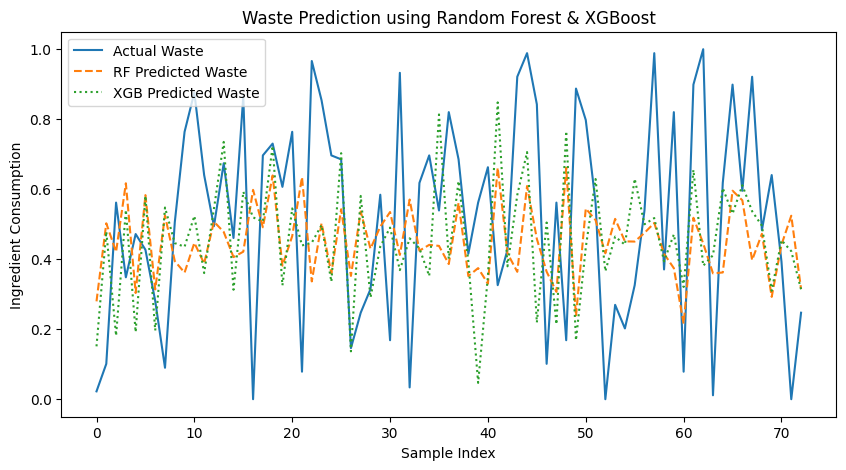

In [29]:
# Visualization - Waste Prediction
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual Waste")
plt.plot(rf_predictions, label="RF Predicted Waste", linestyle='dashed')
plt.plot(xgb_predictions, label="XGB Predicted Waste", linestyle='dotted')
plt.xlabel("Sample Index")
plt.ylabel("Ingredient Consumption")
plt.title("Waste Prediction using Random Forest & XGBoost")
plt.legend()
plt.show()

In [30]:
# ------------------------- REINFORCEMENT LEARNING FOR INVENTORY MANAGEMENT -------------------------
class InventoryEnv(gym.Env):
    def __init__(self):
        self.stock_level = 50  # Initial stock level
        self.max_stock = 100
        self.min_stock = 10
        self.action_space = gym.spaces.Discrete(3)  # Reduce, Maintain, Increase stock
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.int32)

    def step(self, action):
        if action == 0:  # Reduce stock
            self.stock_level = max(self.min_stock, self.stock_level - 10)
        elif action == 2:  # Increase stock
            self.stock_level = min(self.max_stock, self.stock_level + 10)
        reward = -abs(self.stock_level - 50)  # Encourage keeping stock near 50
        return np.array([self.stock_level]), reward, False, {}

    def reset(self):
        self.stock_level = 50
        return np.array([self.stock_level])

env = InventoryEnv()
q_table = np.zeros((101, 3))  # Q-table for stock levels 0-100

In [36]:
# Simple Q-learning training
for episode in range(1000):
    state = env.reset()
    done = False
    step_limit = 1000  # Adjust as needed
    step_count = 0
    epsilon = 0.1  # Adjust between 0 and 1 (higher = more exploration)
    while not done and step_count < step_limit:
        step_count += 1
        print(step_count)
        if np.random.rand() < epsilon:  # Exploration
            action = np.random.choice([0, 1, 2])
        else:  # Exploitation
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)
        if next_state in q_table:
            q_table[state, action] = reward + 0.9 * np.max(q_table[next_state])
        else:
            q_table[state, action] = reward
        state = next_state

# Inventory Replenishment Recommendation
optimal_action = np.argmax(q_table[50])
if optimal_action == 0:
    suggestion = "Reduce Stock"
elif optimal_action == 1:
    suggestion = "Maintain Stock"
else:
    suggestion = "Increase Stock"

# Output results
print("Sales Forecasting Results: Displayed in Graph")
print("\nWaste Prediction Model Metrics:")
print(waste_model_metrics)
print("\nInventory Replenishment Suggestion:", suggestion)


Streaming output truncated to the last 5000 lines.
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
2